# The dataset has been downloaded and stored in the local directory and being used in this instead of a smaller chunk of it.
# In this code a time series problem has been transformed into a supervised learning problem with velocities of 8 previous input time steps and output of 1 future time step.
# The data of only a unique vehicle ID has been fetched and used for the model training and predictions.
# LSTM model has been trained, predictions were made over the test dataset and has been plotted against the true values.
# The entire prediction values of time t has beem tried to compare in a plot.

In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print(tf.__version__)

2024-10-29 19:18:23.843063: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 19:18:23.843109: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 19:18:23.843167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 19:18:23.854364: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [4]:
# Load the CSV file
df = pd.read_csv('Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data_20240819.csv')

# Select the required columns
required_columns = ['Global_X', 'Global_Y', 'v_Vel', 'v_Acc', 'Global_Time', 'Vehicle_ID']
velocity_dataset = df[required_columns]

In [5]:
velocity_dataset.shape

(9455901, 6)

In [6]:
velocity_dataset.head()

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6451203.729,1873252.549,23.31,2.05,1118848075000,515
1,6451203.729,1873252.549,23.31,2.05,1118848075000,515
2,6042814.264,2133542.012,26.54,-0.76,1113437421700,2224
3,6452425.122,1872172.475,37.52,11.20,1118847624800,2127
4,6452347.673,1872258.452,41.99,0.10,1118848324700,1033


In [7]:
velocity_dataset_sorted = velocity_dataset.sort_values(by=['Vehicle_ID', 'Global_Time']).reset_index(drop=True)

In [8]:
velocity_dataset_sorted

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6042841.908,2133120.155,12.50,0.00,1113433136300,1
1,6042839.670,2133135.799,14.64,0.08,1113433137500,1
2,6042839.214,2133138.665,14.59,-0.54,1113433137700,1
3,6042838.525,2133142.971,14.13,-3.49,1113433138000,1
4,6042837.417,2133153.456,13.00,0.00,1113433138800,1
...,...,...,...,...,...,...
9455896,6042608.928,2134671.977,63.93,-11.20,1113433457400,3366
9455897,6042607.952,2134678.398,62.22,-11.20,1113433457500,3366
9455898,6042606.994,2134684.573,62.22,0.00,1113433457600,3366
9455899,6042606.083,2134690.504,62.22,0.00,1113433457700,3366


In [9]:
# Count the number of unique vehicle IDs
unique_vehicle_ids = velocity_dataset['Vehicle_ID'].nunique()
print(f"Number of unique vehicle IDs: {unique_vehicle_ids}")

# Count how many rows of data each vehicle ID has
vehicle_counts = velocity_dataset['Vehicle_ID'].value_counts()

# Display the counts of rows for each vehicle ID
print("\nNumber of rows for each vehicle ID:")
print(vehicle_counts)

Number of unique vehicle IDs: 3233

Number of rows for each vehicle ID:
396     8311
705     7508
567     7441
601     7253
468     7206
        ... 
2897     167
2806      78
2815      70
2810      66
2781      60
Name: Vehicle_ID, Length: 3233, dtype: int64


In [10]:
# Access the count for a particular vehicle ID, and create its single dataset
specific_vehicle_id = 396
num_rows = vehicle_counts[specific_vehicle_id]

print(f"The vehicle ID '{specific_vehicle_id}' has {num_rows} rows of data.")

single_vehicle_data = velocity_dataset_sorted[velocity_dataset_sorted['Vehicle_ID'] == specific_vehicle_id]

The vehicle ID '396' has 8311 rows of data.


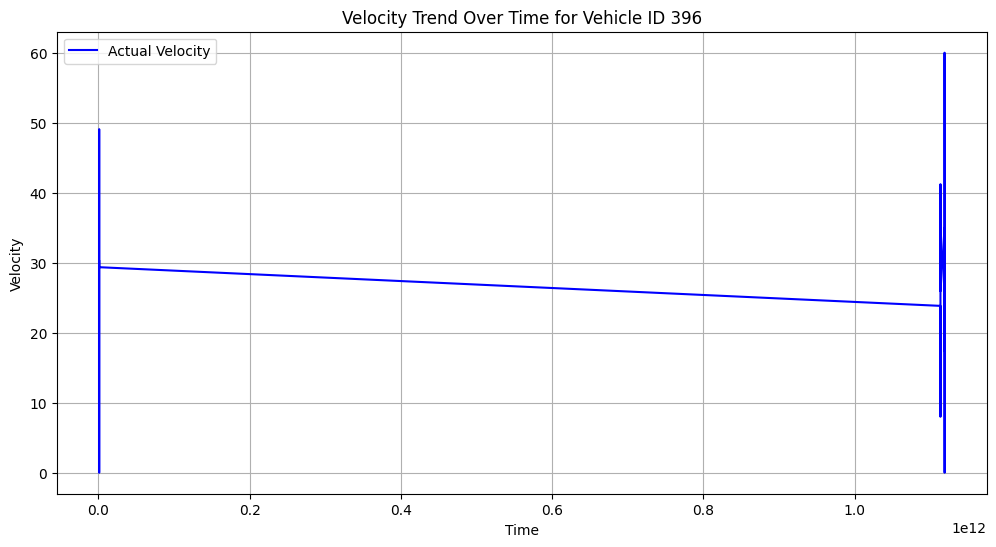

In [11]:
# Extract the time and velocity columns
time = single_vehicle_data['Global_Time'].values
velocity = single_vehicle_data['v_Vel'].values

# Plot the velocity trend over time
plt.figure(figsize=(12, 6))
plt.plot(time, velocity, label='Actual Velocity', color='blue')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity Trend Over Time for Vehicle ID {}'.format(specific_vehicle_id))
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# # Plot velocity over time
# plt.figure(figsize=(12, 6))
# plt.plot(velocity_dataset_sorted['Global_Time'], velocity_dataset_sorted['v_Vel'], label='Velocity')
# plt.xlabel('Global Time (ms)')
# plt.ylabel('Velocity (v_vel)')
# plt.title('Velocity Evolution Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # Ensure data is in 2D format (n_samples, n_features)
    df_s = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_s.shift(i))
        names += [f'var1(t-{i})']
        
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df_s.shift(-i))
        if i == 0:
            names += [f'var1(t)']
        else:
            names += [f'var1(t+{i})']
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [14]:
# Extract the velocity column (assuming 'v_vel' is the velocity column)
velocities = single_vehicle_data['v_Vel'].values

# Convert the velocity time series into a supervised learning problem
n_in = 8  # Number of previous time steps to use as input (8 steps)
n_out = 1  # Number of future time steps to predict (1 step ahead)
supervised_data = series_to_supervised(velocities, n_in=n_in, n_out=n_out)

# Time Steps:   t-8   t-7   t-6   t-5   t-4   t-3   t-2   t-1   t
# Values:      [ x ,  x ,  x ,  x ,  x ,  x ,  x ,  x ] -> [ y ]

# Print the first few rows to verify the transformation
print(supervised_data.head())

    var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  \
8       30.25      30.25      30.25      30.25      30.25      30.25   
9       30.25      30.25      30.25      30.25      30.25      30.24   
10      30.25      30.25      30.25      30.25      30.24      30.24   
11      30.25      30.25      30.25      30.24      30.24      30.24   
12      30.25      30.25      30.24      30.24      30.24      30.24   

    var1(t-2)  var1(t-1)  var1(t)  
8       30.24      30.24    30.24  
9       30.24      30.24    30.24  
10      30.24      30.24    30.23  
11      30.24      30.23    30.23  
12      30.23      30.23    30.23  


In [15]:
# Split the supervised data into training, validation, and test sets
n_train = int(len(supervised_data) * 0.7)
n_validation = int(len(supervised_data) * 0.15)

train_data = supervised_data[:n_train]
validation_data = supervised_data[n_train:n_train + n_validation]
test_data = supervised_data[n_train + n_validation:]

# Separate inputs (X) and outputs (y)
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_validation, y_validation = validation_data.iloc[:, :-1].values, validation_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

# # Print the shapes of the splits to verify
# print("Training features shape:", X_train)
# print("Training labels shape:", y_train)
# print("Validation features shape:", X_validation)
# print("Validation labels shape:", y_validation)
# print("Test features shape:", X_test)
# print("Test labels shape:", y_test)

In [16]:
# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], n_in, 1)) # '1' as here we are working with just one variable v_Vel
X_validation = X_validation.reshape((X_validation.shape[0], n_in, 1))
X_test = X_test.reshape((X_test.shape[0], n_in, 1))

In [17]:
print(X_test.shape)
print(y_test.shape)

(1246, 8, 1)
(1246,)


In [34]:
# Define the LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                         validation_data=(X_validation, y_validation), 
                         verbose=1, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = lstm_model.evaluate(X_test, y_test, batch_size=len(X_test), verbose=1) # verbose=1 : Progress bar mode - displays a progress bar with training and validation metrics
print(f"Test Loss: {test_loss}")

# Compute RMSE
rmse = np.sqrt(test_loss)
print(f"RMSE on the test set: {rmse:.4f}")

Epoch 1/50
182/182 [==============================] - 20s 68ms/step - loss: 122.8753 - val_loss: 10.6264
Epoch 2/50
182/182 [==============================] - 12s 64ms/step - loss: 61.3966 - val_loss: 11.1025
Epoch 3/50
182/182 [==============================] - 12s 65ms/step - loss: 57.3709 - val_loss: 10.2488
Epoch 4/50
182/182 [==============================] - 12s 64ms/step - loss: 49.0325 - val_loss: 13.5314
Epoch 5/50
182/182 [==============================] - 11s 62ms/step - loss: 46.4824 - val_loss: 9.9428
Epoch 6/50
182/182 [==============================] - 12s 64ms/step - loss: 42.7263 - val_loss: 9.5493
Epoch 7/50
182/182 [==============================] - 12s 67ms/step - loss: 39.7172 - val_loss: 8.9867
Epoch 8/50
182/182 [==============================] - 12s 63ms/step - loss: 38.9305 - val_loss: 11.6558
Epoch 9/50
182/182 [==============================] - 12s 65ms/step - loss: 36.6490 - val_loss: 6.0050
Epoch 10/50
182/182 [==============================] - 12s 65ms/ste

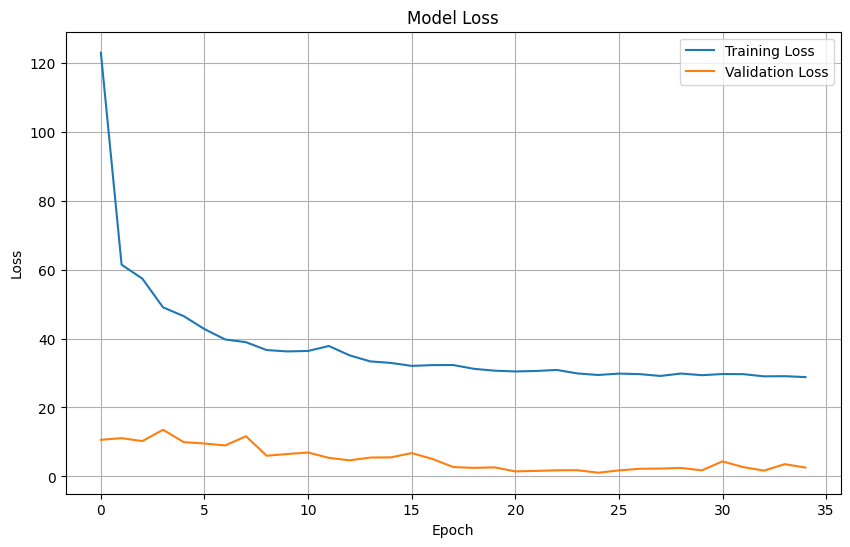

In [35]:
# Plotting training & validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss'), label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [36]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 8, 128)            66560     
                                                                 
 lstm_16 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_17 (LSTM)              (None, 8, 64)             33024     
                                                                 
 lstm_18 (LSTM)              (None, 8, 32)             12416     
                                                                 
 lstm_19 (LSTM)              (None, 8, 32)             8320      
                                                                 
 lstm_20 (LSTM)              (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                

In [37]:
#  # Define the LSTM model
#  lstm_model = tf.keras.Sequential([tf.keras.layers.input(1,1)
#      tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True),
#      tf.keras.layers.Dense(32, activation='relu', return_sequences=True),
#      tf.keras.layers.Dense(32, activation='relu', return_sequences=False),
#      tf.keras.layers.Dense(1)
#  ])

In [38]:
# Test predictions over the entire test dataset
X_test_copy = X_test.copy()  # Copy the test data to avoid modifying the original
predictions = []

# Loop through each sample in the test dataset
for i in range(len(X_test_copy)):
    # Extract the current sequence (8 time steps)
    current_sequence = X_test_copy[i]  # Get the ith row
    
    # Reshape it to the correct shape for prediction: (1, 8, 1)
    current_sequence = current_sequence.reshape(1, current_sequence.shape[0], 1)
    
    # Debugging print statements
    print(f"i = {i}, current_sequence shape = {current_sequence.shape}")
    
    # Predict the next velocity based on the current sequence
    next_velocity = lstm_model.predict(current_sequence, verbose=0) # verbose=0 : Silent mode - no output during training
    
    # Append the predicted velocity to the predictions list
    predictions.append(next_velocity[0, 0])
    
    # Replace the original value in the test set with the predicted one
    if i < len(X_test_copy) - 1:  # Prevent index out of range error
        X_test_copy[i + 1, -1, 0] = next_velocity[0, 0]

# Print the predicted velocities for the test dataset
print("Predicted velocities for the test dataset are:", predictions)

i = 0, current_sequence shape = (1, 8, 1)
i = 1, current_sequence shape = (1, 8, 1)
i = 2, current_sequence shape = (1, 8, 1)
i = 3, current_sequence shape = (1, 8, 1)
i = 4, current_sequence shape = (1, 8, 1)
i = 5, current_sequence shape = (1, 8, 1)
i = 6, current_sequence shape = (1, 8, 1)
i = 7, current_sequence shape = (1, 8, 1)
i = 8, current_sequence shape = (1, 8, 1)
i = 9, current_sequence shape = (1, 8, 1)
i = 10, current_sequence shape = (1, 8, 1)
i = 11, current_sequence shape = (1, 8, 1)
i = 12, current_sequence shape = (1, 8, 1)
i = 13, current_sequence shape = (1, 8, 1)
i = 14, current_sequence shape = (1, 8, 1)
i = 15, current_sequence shape = (1, 8, 1)
i = 16, current_sequence shape = (1, 8, 1)
i = 17, current_sequence shape = (1, 8, 1)
i = 18, current_sequence shape = (1, 8, 1)
i = 19, current_sequence shape = (1, 8, 1)
i = 20, current_sequence shape = (1, 8, 1)
i = 21, current_sequence shape = (1, 8, 1)
i = 22, current_sequence shape = (1, 8, 1)
i = 23, current_seque

i = 191, current_sequence shape = (1, 8, 1)
i = 192, current_sequence shape = (1, 8, 1)
i = 193, current_sequence shape = (1, 8, 1)
i = 194, current_sequence shape = (1, 8, 1)
i = 195, current_sequence shape = (1, 8, 1)
i = 196, current_sequence shape = (1, 8, 1)
i = 197, current_sequence shape = (1, 8, 1)
i = 198, current_sequence shape = (1, 8, 1)
i = 199, current_sequence shape = (1, 8, 1)
i = 200, current_sequence shape = (1, 8, 1)
i = 201, current_sequence shape = (1, 8, 1)
i = 202, current_sequence shape = (1, 8, 1)
i = 203, current_sequence shape = (1, 8, 1)
i = 204, current_sequence shape = (1, 8, 1)
i = 205, current_sequence shape = (1, 8, 1)
i = 206, current_sequence shape = (1, 8, 1)
i = 207, current_sequence shape = (1, 8, 1)
i = 208, current_sequence shape = (1, 8, 1)
i = 209, current_sequence shape = (1, 8, 1)
i = 210, current_sequence shape = (1, 8, 1)
i = 211, current_sequence shape = (1, 8, 1)
i = 212, current_sequence shape = (1, 8, 1)
i = 213, current_sequence shape 

i = 379, current_sequence shape = (1, 8, 1)
i = 380, current_sequence shape = (1, 8, 1)
i = 381, current_sequence shape = (1, 8, 1)
i = 382, current_sequence shape = (1, 8, 1)
i = 383, current_sequence shape = (1, 8, 1)
i = 384, current_sequence shape = (1, 8, 1)
i = 385, current_sequence shape = (1, 8, 1)
i = 386, current_sequence shape = (1, 8, 1)
i = 387, current_sequence shape = (1, 8, 1)
i = 388, current_sequence shape = (1, 8, 1)
i = 389, current_sequence shape = (1, 8, 1)
i = 390, current_sequence shape = (1, 8, 1)
i = 391, current_sequence shape = (1, 8, 1)
i = 392, current_sequence shape = (1, 8, 1)
i = 393, current_sequence shape = (1, 8, 1)
i = 394, current_sequence shape = (1, 8, 1)
i = 395, current_sequence shape = (1, 8, 1)
i = 396, current_sequence shape = (1, 8, 1)
i = 397, current_sequence shape = (1, 8, 1)
i = 398, current_sequence shape = (1, 8, 1)
i = 399, current_sequence shape = (1, 8, 1)
i = 400, current_sequence shape = (1, 8, 1)
i = 401, current_sequence shape 

i = 567, current_sequence shape = (1, 8, 1)
i = 568, current_sequence shape = (1, 8, 1)
i = 569, current_sequence shape = (1, 8, 1)
i = 570, current_sequence shape = (1, 8, 1)
i = 571, current_sequence shape = (1, 8, 1)
i = 572, current_sequence shape = (1, 8, 1)
i = 573, current_sequence shape = (1, 8, 1)
i = 574, current_sequence shape = (1, 8, 1)
i = 575, current_sequence shape = (1, 8, 1)
i = 576, current_sequence shape = (1, 8, 1)
i = 577, current_sequence shape = (1, 8, 1)
i = 578, current_sequence shape = (1, 8, 1)
i = 579, current_sequence shape = (1, 8, 1)
i = 580, current_sequence shape = (1, 8, 1)
i = 581, current_sequence shape = (1, 8, 1)
i = 582, current_sequence shape = (1, 8, 1)
i = 583, current_sequence shape = (1, 8, 1)
i = 584, current_sequence shape = (1, 8, 1)
i = 585, current_sequence shape = (1, 8, 1)
i = 586, current_sequence shape = (1, 8, 1)
i = 587, current_sequence shape = (1, 8, 1)
i = 588, current_sequence shape = (1, 8, 1)
i = 589, current_sequence shape 

i = 754, current_sequence shape = (1, 8, 1)
i = 755, current_sequence shape = (1, 8, 1)
i = 756, current_sequence shape = (1, 8, 1)
i = 757, current_sequence shape = (1, 8, 1)
i = 758, current_sequence shape = (1, 8, 1)
i = 759, current_sequence shape = (1, 8, 1)
i = 760, current_sequence shape = (1, 8, 1)
i = 761, current_sequence shape = (1, 8, 1)
i = 762, current_sequence shape = (1, 8, 1)
i = 763, current_sequence shape = (1, 8, 1)
i = 764, current_sequence shape = (1, 8, 1)
i = 765, current_sequence shape = (1, 8, 1)
i = 766, current_sequence shape = (1, 8, 1)
i = 767, current_sequence shape = (1, 8, 1)
i = 768, current_sequence shape = (1, 8, 1)
i = 769, current_sequence shape = (1, 8, 1)
i = 770, current_sequence shape = (1, 8, 1)
i = 771, current_sequence shape = (1, 8, 1)
i = 772, current_sequence shape = (1, 8, 1)
i = 773, current_sequence shape = (1, 8, 1)
i = 774, current_sequence shape = (1, 8, 1)
i = 775, current_sequence shape = (1, 8, 1)
i = 776, current_sequence shape 

i = 941, current_sequence shape = (1, 8, 1)
i = 942, current_sequence shape = (1, 8, 1)
i = 943, current_sequence shape = (1, 8, 1)
i = 944, current_sequence shape = (1, 8, 1)
i = 945, current_sequence shape = (1, 8, 1)
i = 946, current_sequence shape = (1, 8, 1)
i = 947, current_sequence shape = (1, 8, 1)
i = 948, current_sequence shape = (1, 8, 1)
i = 949, current_sequence shape = (1, 8, 1)
i = 950, current_sequence shape = (1, 8, 1)
i = 951, current_sequence shape = (1, 8, 1)
i = 952, current_sequence shape = (1, 8, 1)
i = 953, current_sequence shape = (1, 8, 1)
i = 954, current_sequence shape = (1, 8, 1)
i = 955, current_sequence shape = (1, 8, 1)
i = 956, current_sequence shape = (1, 8, 1)
i = 957, current_sequence shape = (1, 8, 1)
i = 958, current_sequence shape = (1, 8, 1)
i = 959, current_sequence shape = (1, 8, 1)
i = 960, current_sequence shape = (1, 8, 1)
i = 961, current_sequence shape = (1, 8, 1)
i = 962, current_sequence shape = (1, 8, 1)
i = 963, current_sequence shape 

i = 1125, current_sequence shape = (1, 8, 1)
i = 1126, current_sequence shape = (1, 8, 1)
i = 1127, current_sequence shape = (1, 8, 1)
i = 1128, current_sequence shape = (1, 8, 1)
i = 1129, current_sequence shape = (1, 8, 1)
i = 1130, current_sequence shape = (1, 8, 1)
i = 1131, current_sequence shape = (1, 8, 1)
i = 1132, current_sequence shape = (1, 8, 1)
i = 1133, current_sequence shape = (1, 8, 1)
i = 1134, current_sequence shape = (1, 8, 1)
i = 1135, current_sequence shape = (1, 8, 1)
i = 1136, current_sequence shape = (1, 8, 1)
i = 1137, current_sequence shape = (1, 8, 1)
i = 1138, current_sequence shape = (1, 8, 1)
i = 1139, current_sequence shape = (1, 8, 1)
i = 1140, current_sequence shape = (1, 8, 1)
i = 1141, current_sequence shape = (1, 8, 1)
i = 1142, current_sequence shape = (1, 8, 1)
i = 1143, current_sequence shape = (1, 8, 1)
i = 1144, current_sequence shape = (1, 8, 1)
i = 1145, current_sequence shape = (1, 8, 1)
i = 1146, current_sequence shape = (1, 8, 1)
i = 1147, 

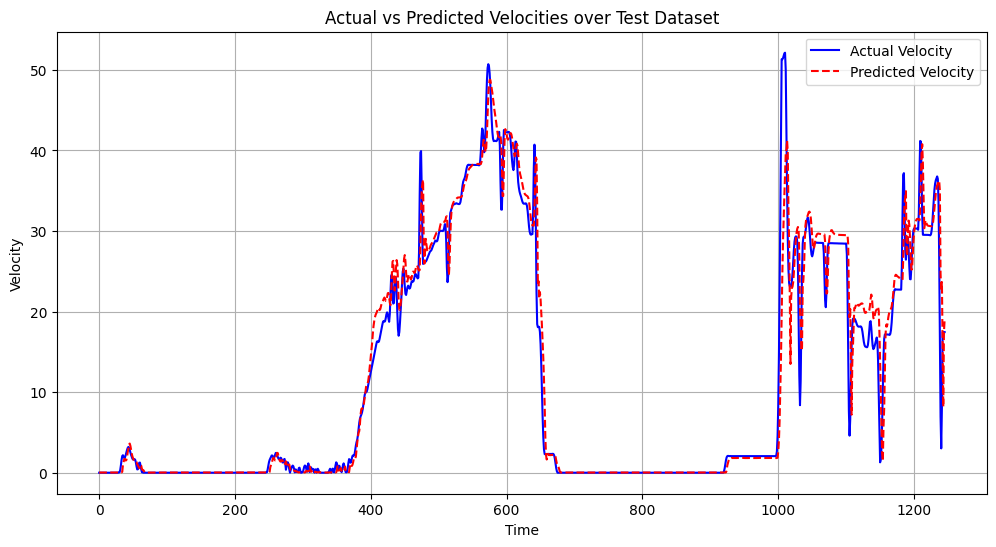

In [39]:
# Assuming y_test contains the true velocities
true_velocities = y_test

# Assuming predictions contain the predicted velocities
predicted_velocities = np.array(predictions)  # Convert to numpy array if it's not already

# Create time indices for the test dataset
time_indices = np.arange(len(true_velocities))

# Create a DataFrame to store the actual and predicted velocities with the time indices
results_df = pd.DataFrame({
    'Time': time_indices,
    'Actual Velocity': true_velocities,
    'Predicted Velocity': predicted_velocities
})

# Plotting the actual and predicted velocities
plt.figure(figsize=(12, 6))

# Plot the actual velocities
plt.plot(results_df['Time'], results_df['Actual Velocity'], label='Actual Velocity', color='blue')

# Plot the predicted velocities
plt.plot(results_df['Time'], results_df['Predicted Velocity'], label='Predicted Velocity', color='red', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Actual vs Predicted Velocities over Test Dataset')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [40]:
# Ensure both DataFrames have identical rows and columns
assert true_velocities.shape == predicted_velocities.shape, "Datasets must have the same shape!"

# Calculate RMSE using the mathematical formula
def calculate_rmse(true_values, predicted_values):
    # Calculate the mean square error
    mse = np.mean((true_values - predicted_values) ** 2)
    # Take the square root of the mean square error to get RMSE
    rmse = np.sqrt(mse)
    return rmse

# Apply RMSE calculation on all values
rmse = calculate_rmse(true_velocities, predicted_velocities)

print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 3.3304877320530064


In [ ]:
### ADDITIONAL LINE OF CODES ###

# Use the last known sequence from the test set for prediction
last_sequence = X_test[-1]

# Number of future steps to predict
n_steps = 5
predictions = []

for _ in range(n_steps):
    # Predict the next velocity
    next_velocity = lstm_model.predict(last_sequence.reshape(1, last_sequence.shape[0], 1), verbose=0)
    
    # Append the predicted velocity to the predictions list
    predictions.append(next_velocity[0, 0])
    
    # Update the sequence: remove the oldest velocity and add the predicted one
    last_sequence = np.append(last_sequence[1:], next_velocity[0, 0]).reshape(-1, 1)

# Print the predicted velocities for the next 5 steps
print("Predicted velocities for the next 5 time steps:", predictions)

# Optionally convert the predictions into a DataFrame or append them to an existing DataFrame
predicted_df = pd.DataFrame(predictions, columns=['Predicted Velocity'])

print(predicted_df)

In [ ]:
# the last known time in your dataset is `last_known_time`
last_known_time = single_vehicle_data['Global_Time'].iloc[-1]

# Generate future time steps (1 timestep in future)
future_time = np.arange(last_known_time + 1, last_known_time + 1 + len(predictions))

# Append these predictions to the original time and velocity arrays for plotting
extended_time = np.append(time, future_time)
extended_velocity = np.append(velocity, predictions)

# Plot the original velocity trend
plt.figure(figsize=(12, 6))
plt.plot(time, velocity, label='Actual Velocity', color='blue')

# Plot the predicted velocities
plt.plot(future_time, predictions, label='Predicted Velocity', color='red', linestyle='--')

# Highlight the predicted points with markers
plt.scatter(future_time, predictions, color='red', marker='o')

# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity Trend and Future Predictions for Vehicle ID {}'.format(specific_vehicle_id))
plt.legend()
plt.grid(True)
plt.show()
